In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, accuracy_score, average_precision_score


def get_dbl_metrics(test, score):
    fig = plt.figure(figsize=(6,3),dpi=100)

    plt.subplot(1,2,1)
    #ROC 
    fpr, tpr, thresholds = metrics.roc_curve(test, score, pos_label=1)
    rauc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,lw=2, label='ROC curve (area = %0.2f)' % rauc)
    plt.plot([0,1],[0,1],'--',color ='black', lw=1)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC (area = %0.2f)' % rauc)

    plt.subplot(1,2,2)
    # precision recall curve
    precision, recall, thresholds = precision_recall_curve(test, score, pos_label=1)
    prauc = metrics.auc(recall, precision)
    plt.plot(recall, precision, lw=2)
    random=len(test[test==1]) / len(test)
    plt.plot([0, 1], [random, random], linestyle='--', label='random', c='black', lw=1)
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.title("PR curve (area = %0.2f)" % prauc)

    plt.tight_layout()
    
    ap = average_precision_score(test, score)
    
    return rauc, prauc, ap

def mk_heatmap(hm, title = 'Heatmap'):
    fig, ax = plt.subplots(1, 1, dpi=300)
    #cbar_ax = fig.add_axes([.95, .25, .05, .5])
    cbar_kws = {"orientation":"horizontal", 
                "shrink":0.7,
                'extendfrac':0.1, 
                "drawedges":False,
               }
    
    #(hm.subtract(hm.min(axis=1), axis=0)).div((hm.max(axis=1) - hm.min(axis=1)), axis=0)
    
    ax=sns.heatmap(hm, square=False, ax=ax, cbar=True, cmap="YlOrRd", annot=(np.round(hm,2)*100).astype(int),  fmt='g')#, cbar_kws=cbar_kws) #YlOrRd
    ax.set_yticklabels(ax.get_yticklabels(),rotation=45)
    ax.set_title(title, fontsize=18)


pbmc-2stim-dm
../results_knn/sce_normalized_data_inflate/
J293t-dm
../results_knn/sce_normalized_data_inflate/
HEK-HMEC-MULTI
../results_knn/sce_normalized_data_inflate/


/data/home/hannah/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


pbmc-1A-dm
../results_knn/sce_normalized_data_inflate/
cline-ch
../results_knn/sce_normalized_data_inflate/
hm-12k
../results_knn/sce_normalized_data_inflate/
hm-6k
../results_knn/sce_normalized_data_inflate/
HMEC-orig-MULTI
../results_knn/sce_normalized_data_inflate/
HMEC-rep-MULTI
../results_knn/sce_normalized_data_inflate/
mkidney-ch
../results_knn/sce_normalized_data_inflate/
nuc-MULTI
../results_knn/sce_normalized_data_inflate/
pbmc-1B-dm
../results_knn/sce_normalized_data_inflate/
pbmc-1C-dm
../results_knn/sce_normalized_data_inflate/
pbmc-2ctrl-dm
../results_knn/sce_normalized_data_inflate/
pbmc-ch
../results_knn/sce_normalized_data_inflate/
pdx-MULTI
../results_knn/sce_normalized_data_inflate/


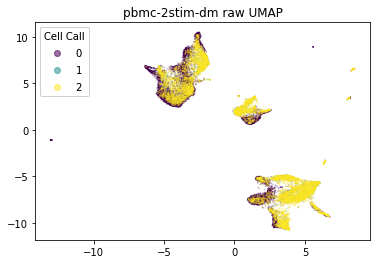

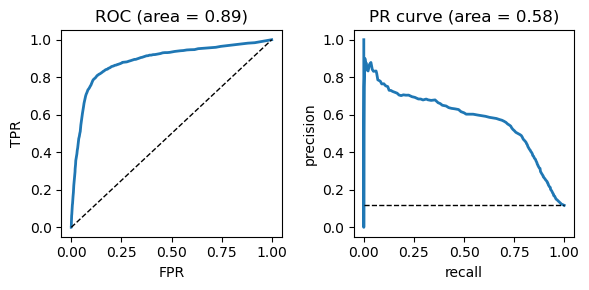

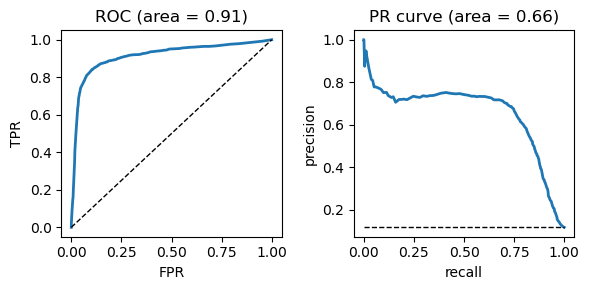

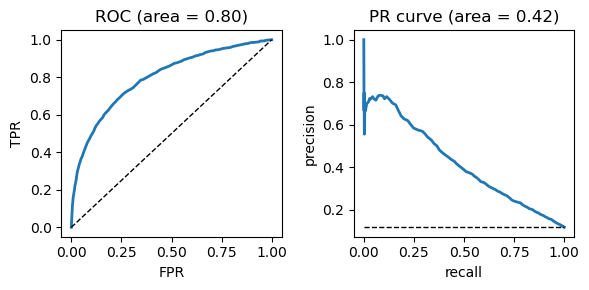

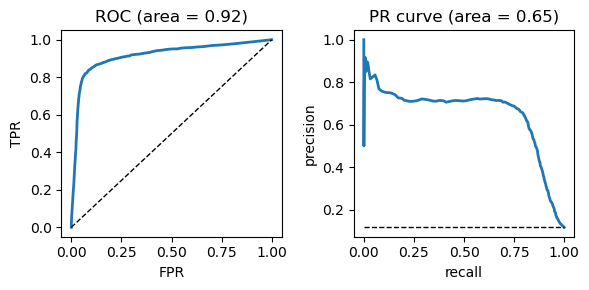

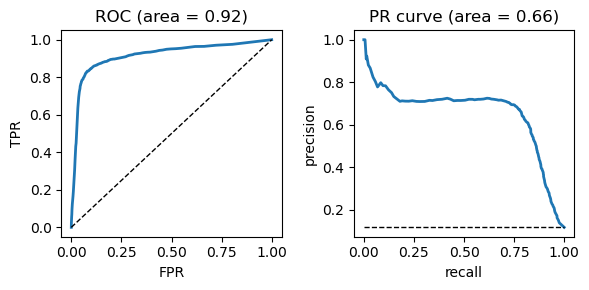

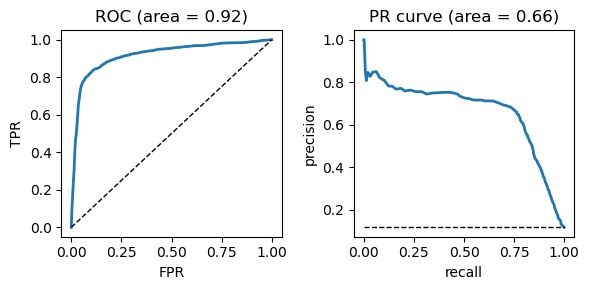

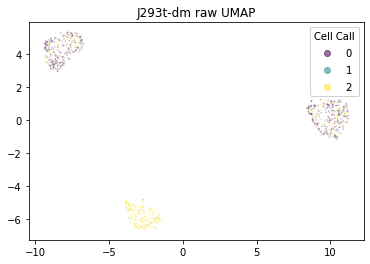

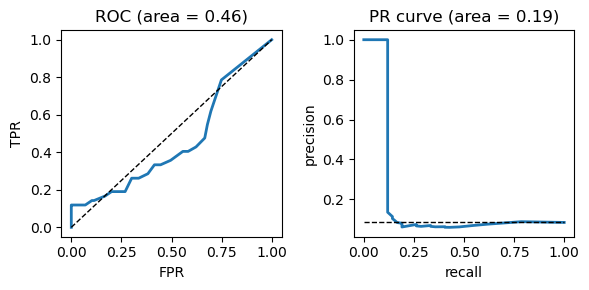

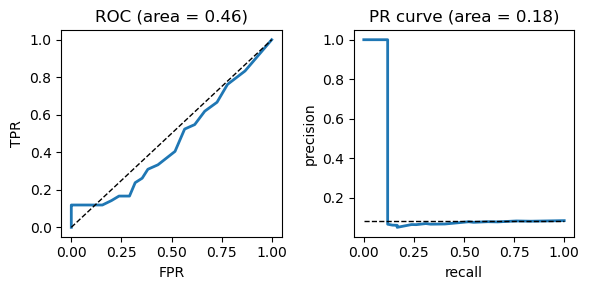

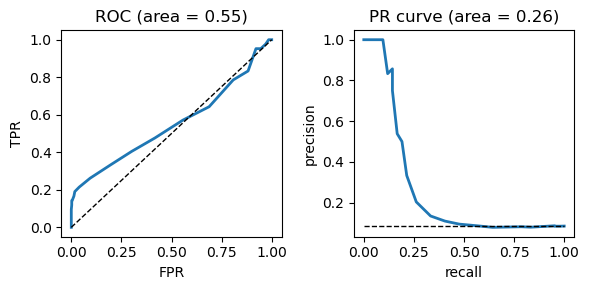

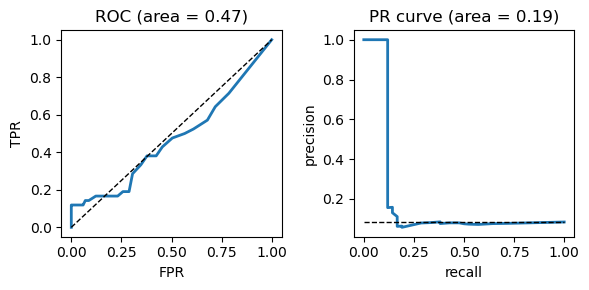

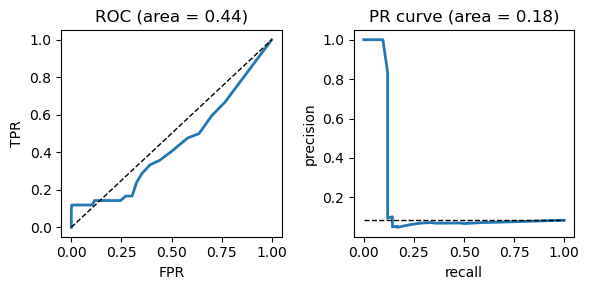

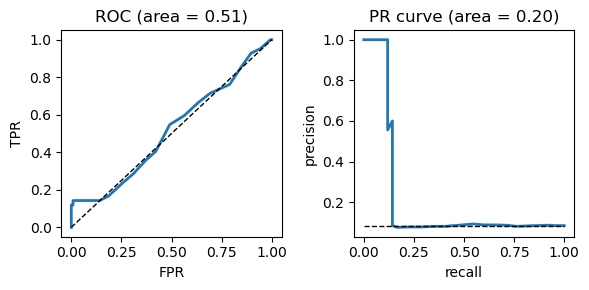

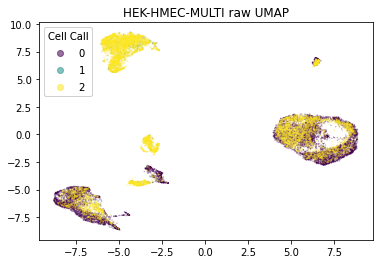

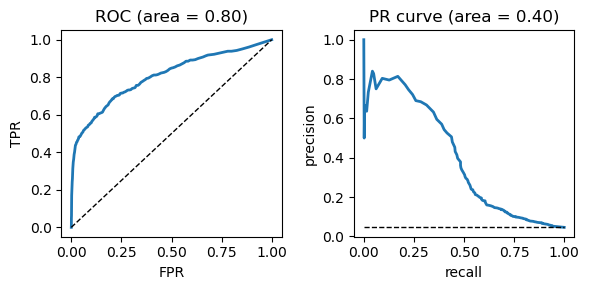

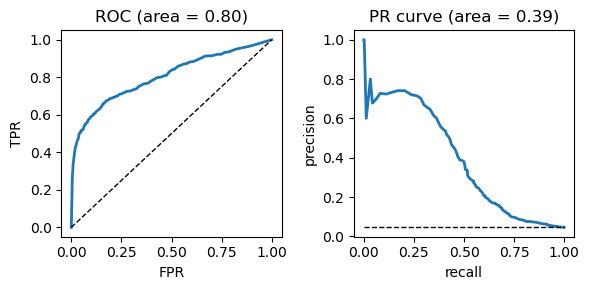

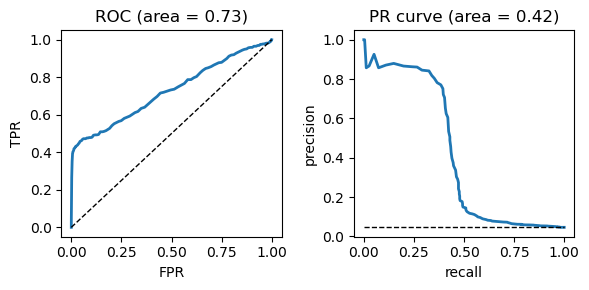

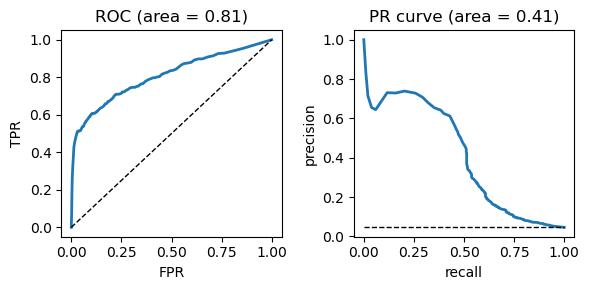

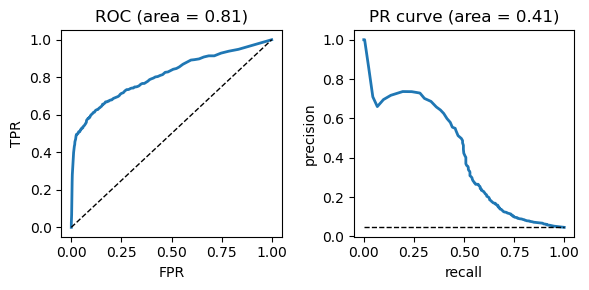

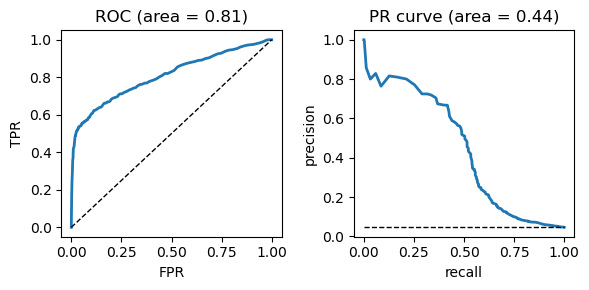

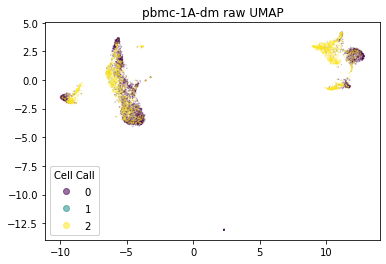

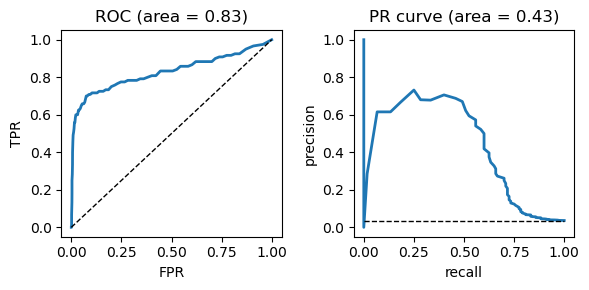

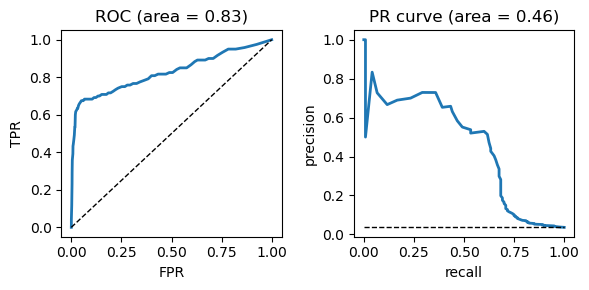

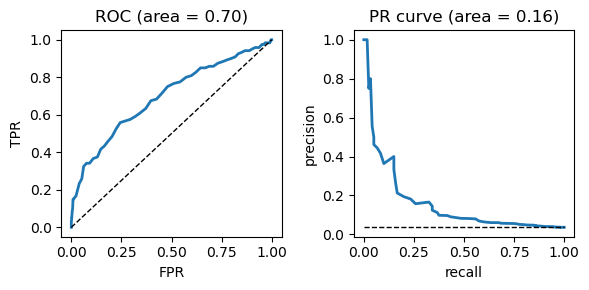

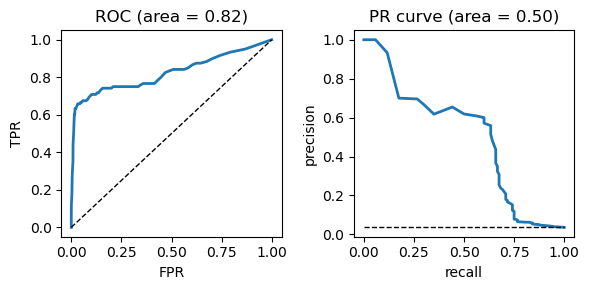

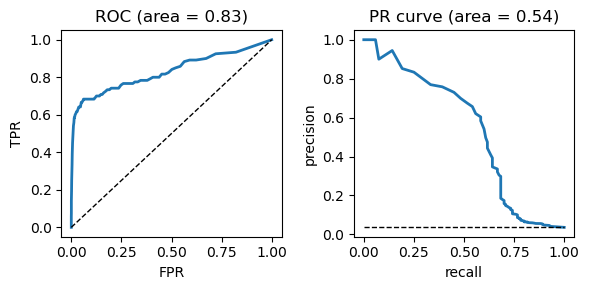

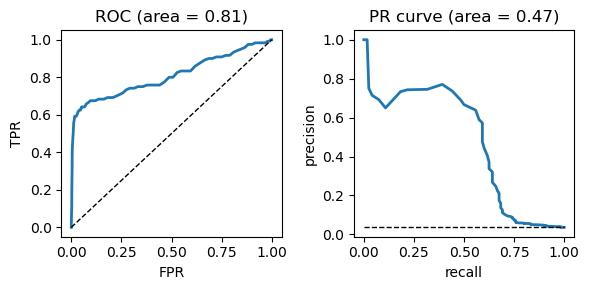

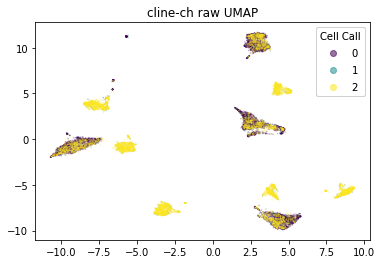

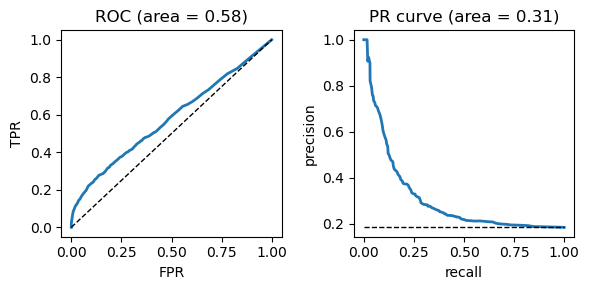

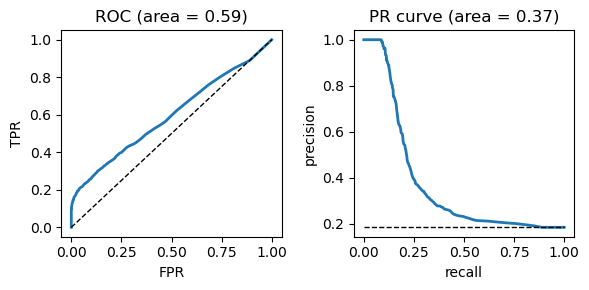

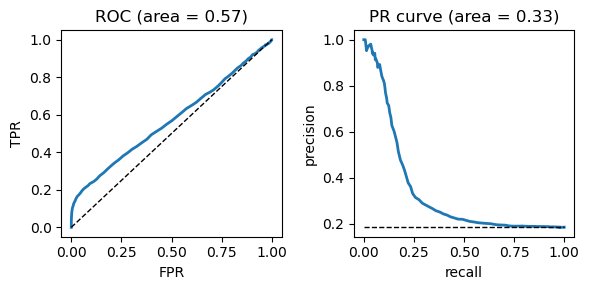

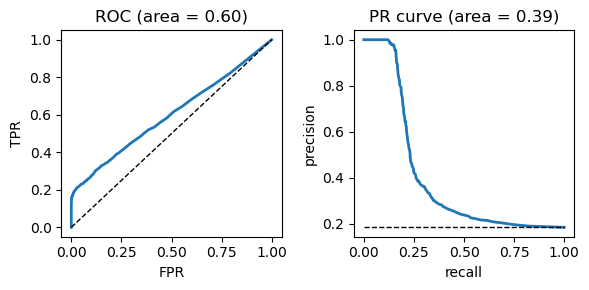

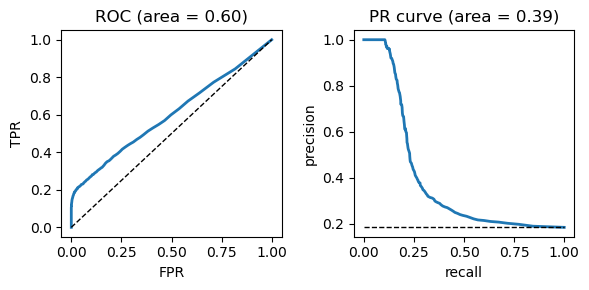

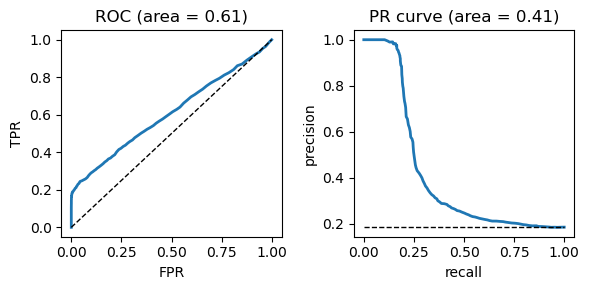

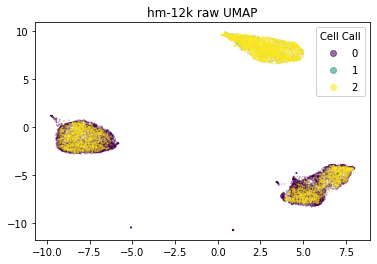

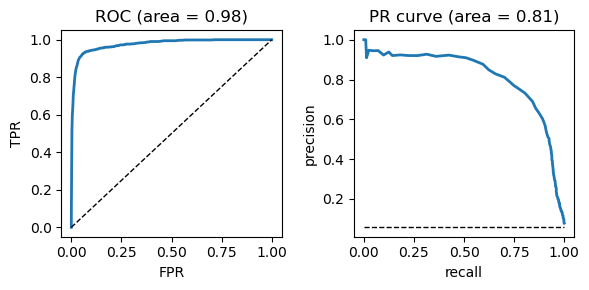

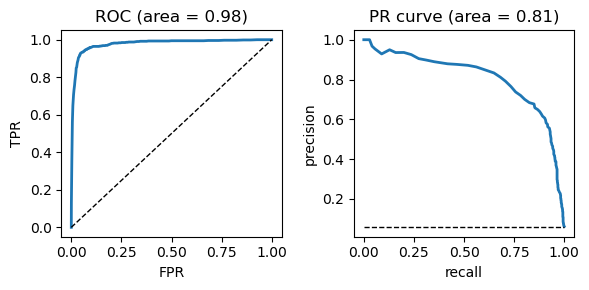

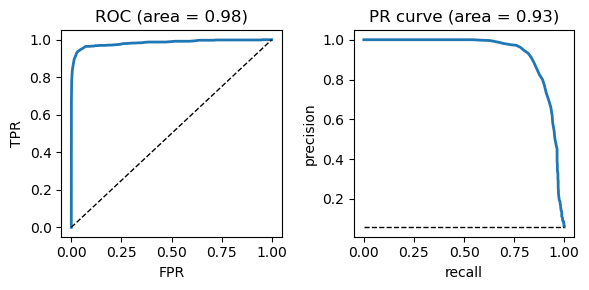

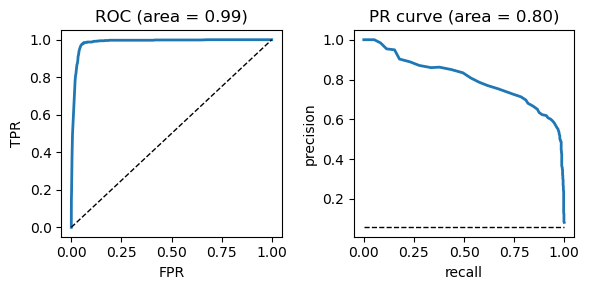

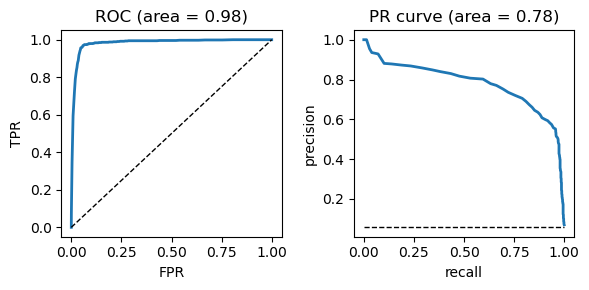

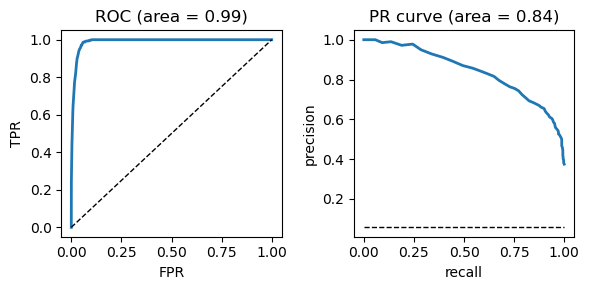

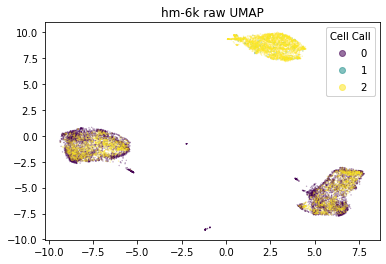

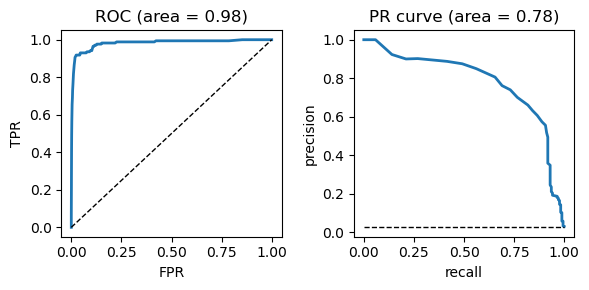

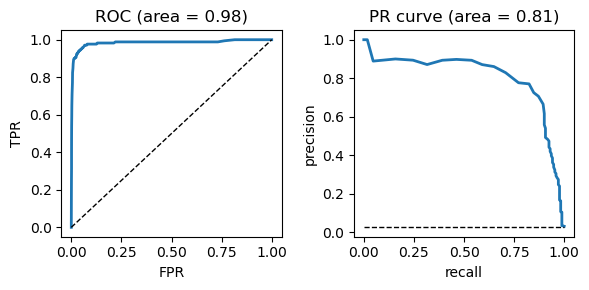

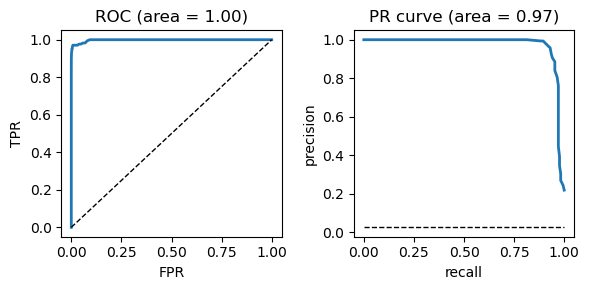

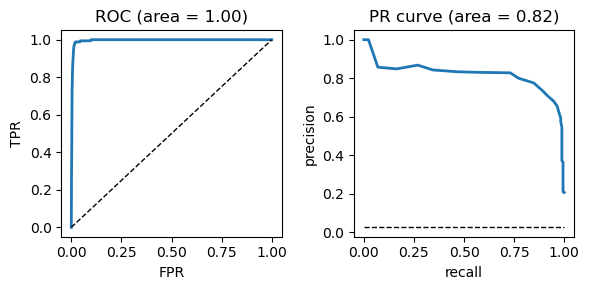

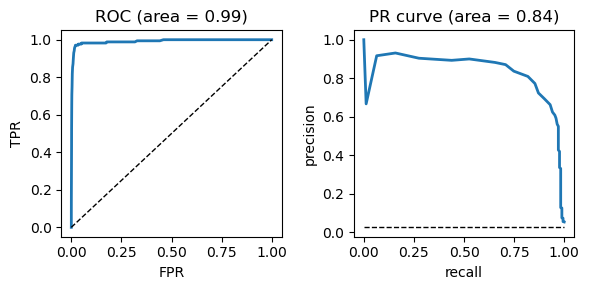

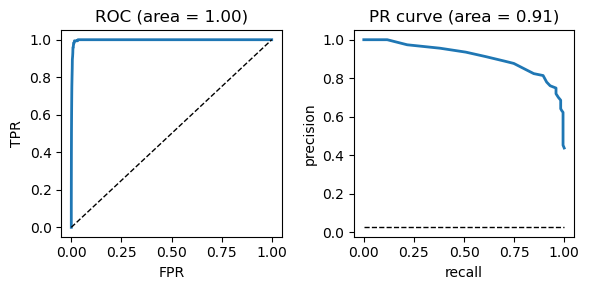

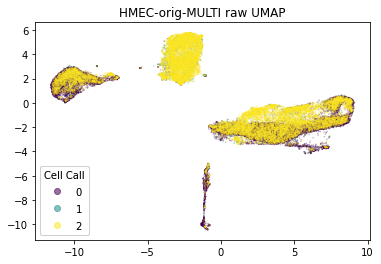

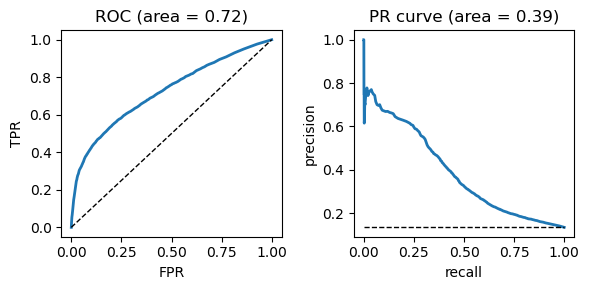

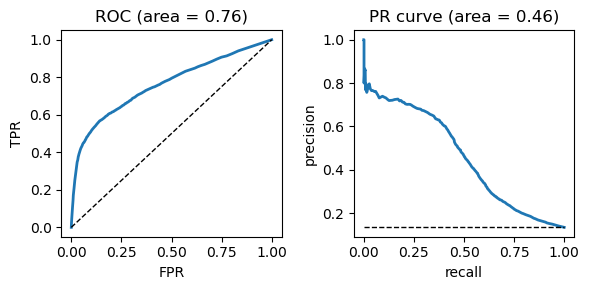

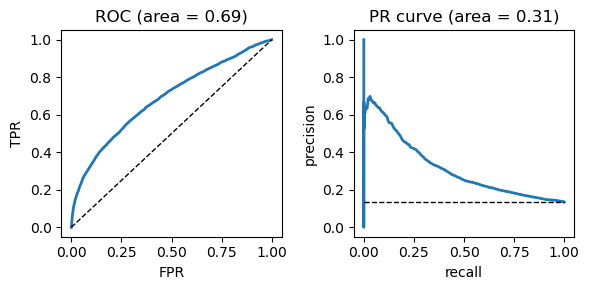

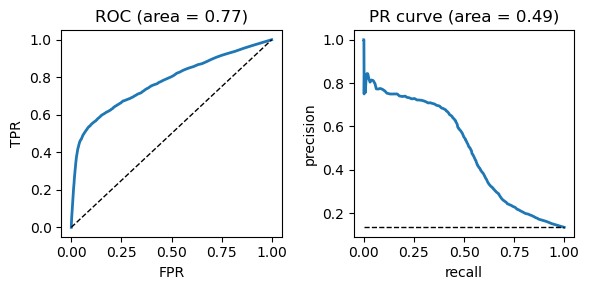

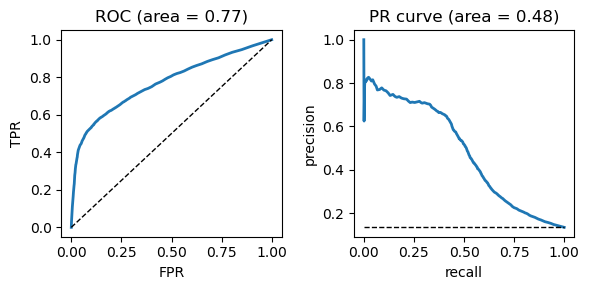

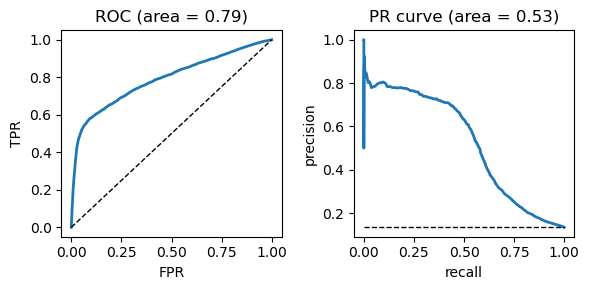

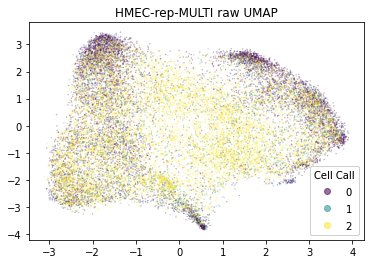

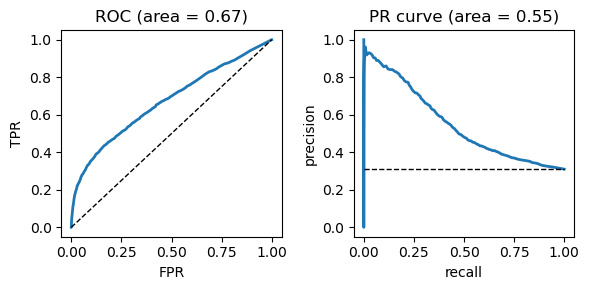

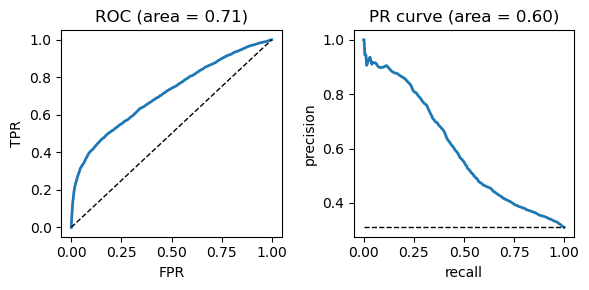

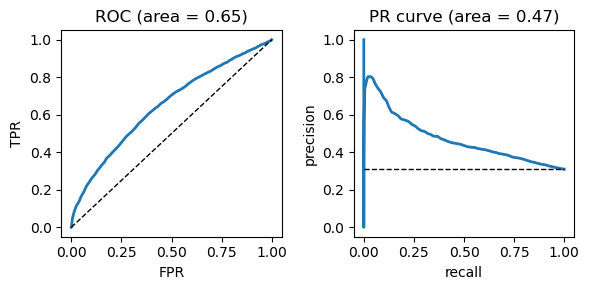

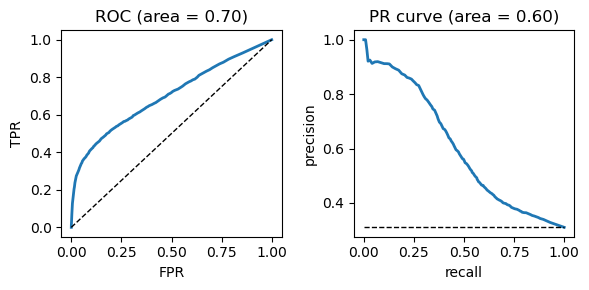

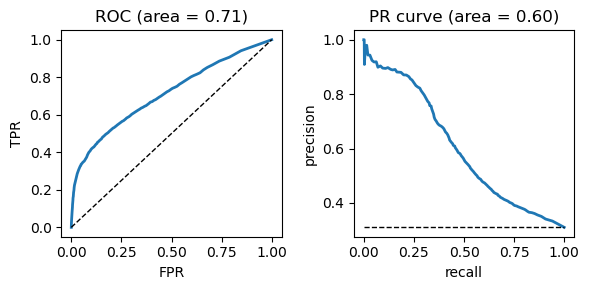

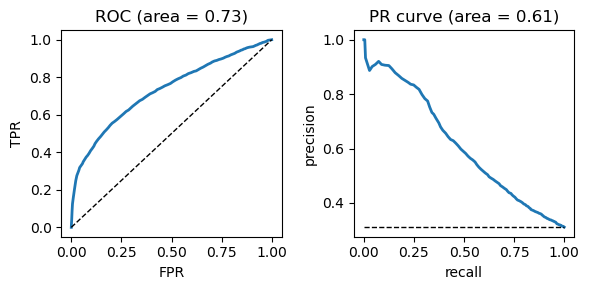

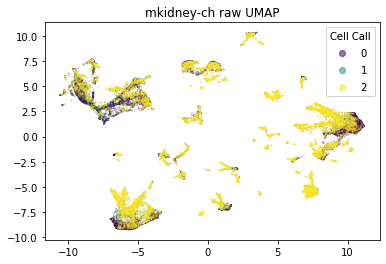

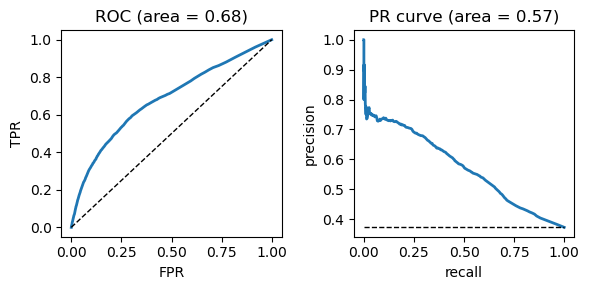

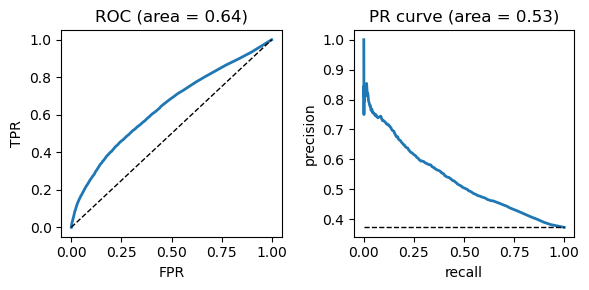

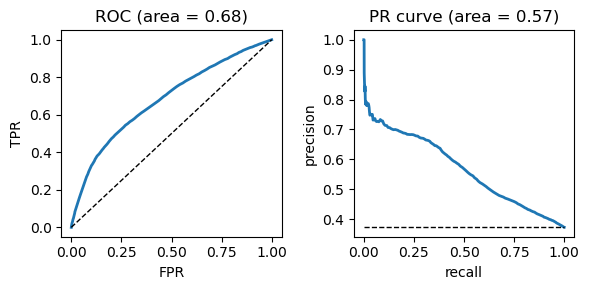

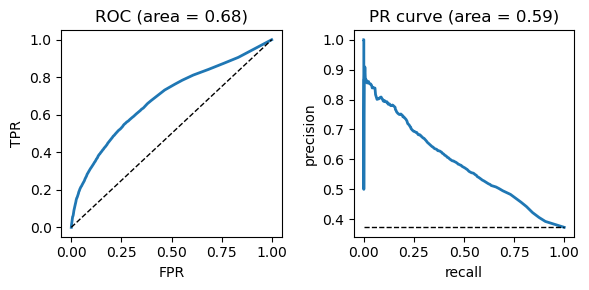

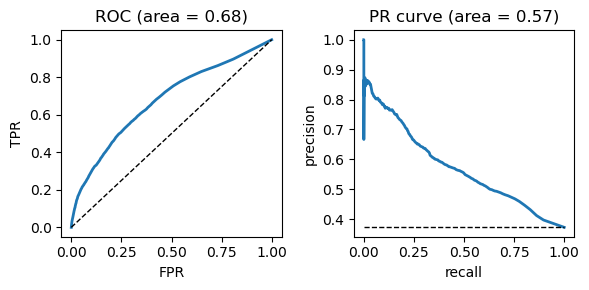

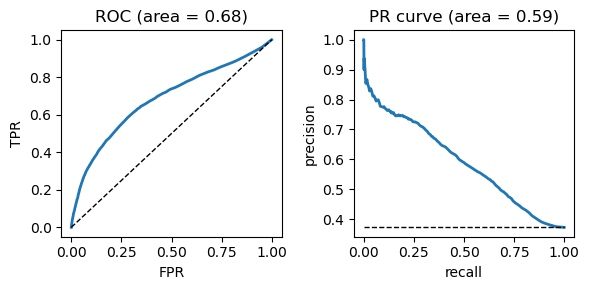

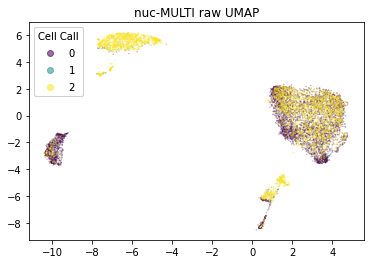

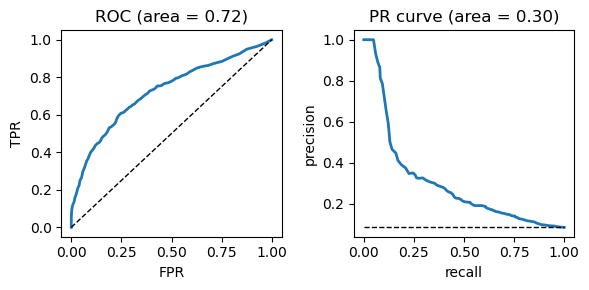

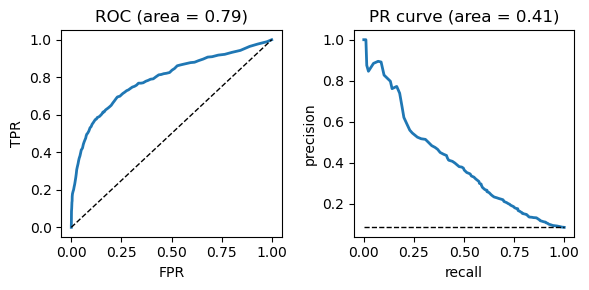

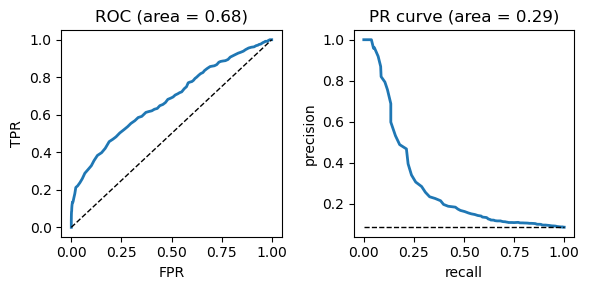

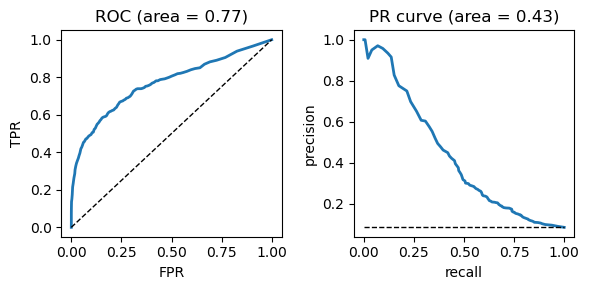

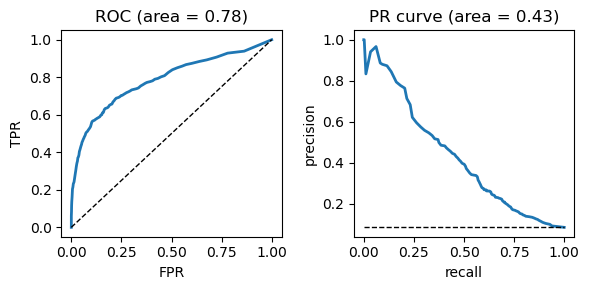

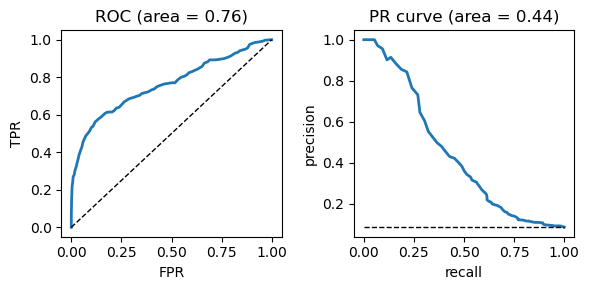

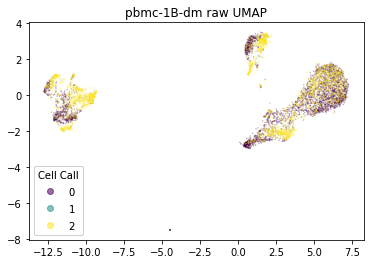

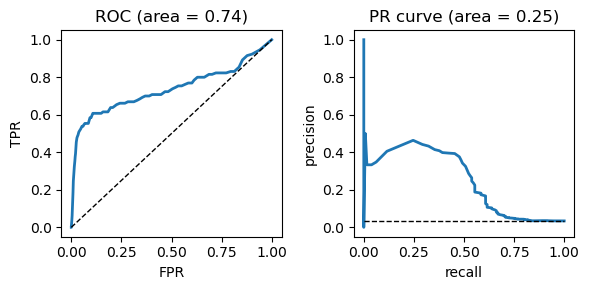

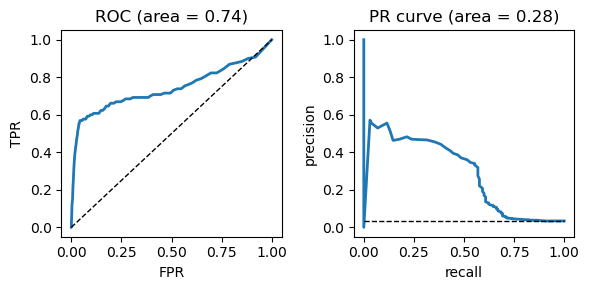

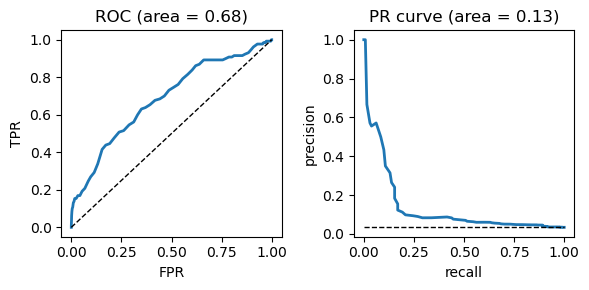

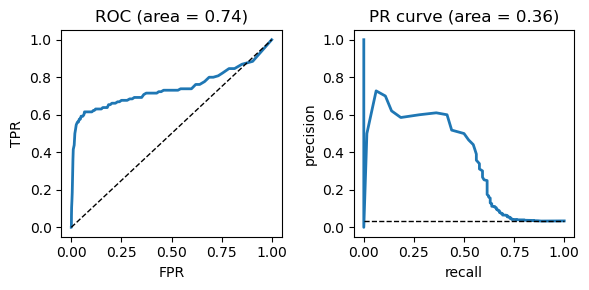

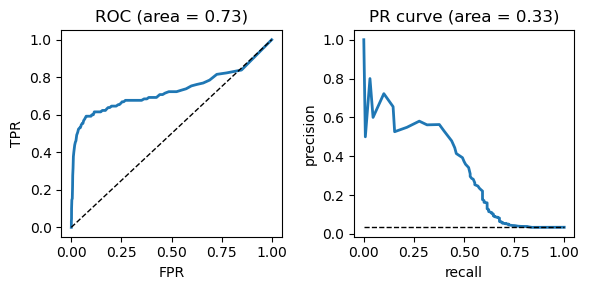

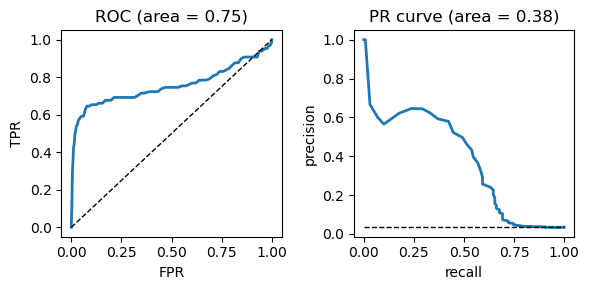

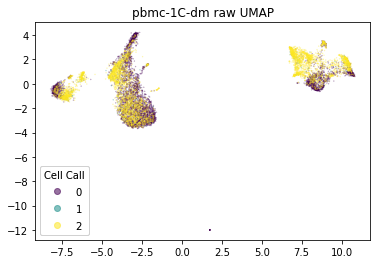

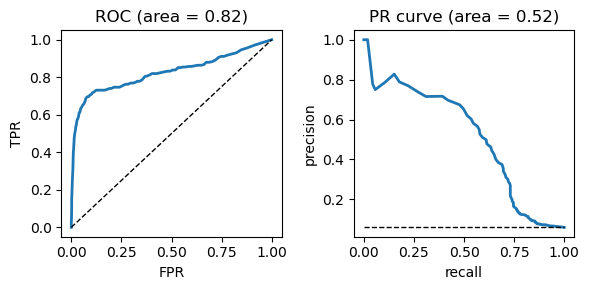

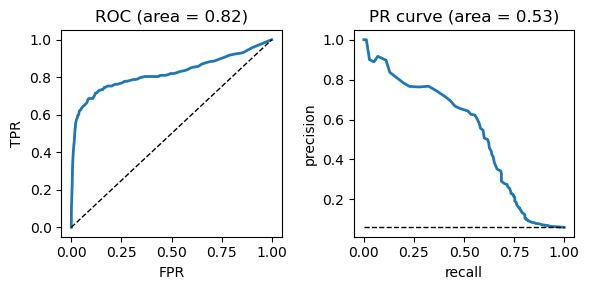

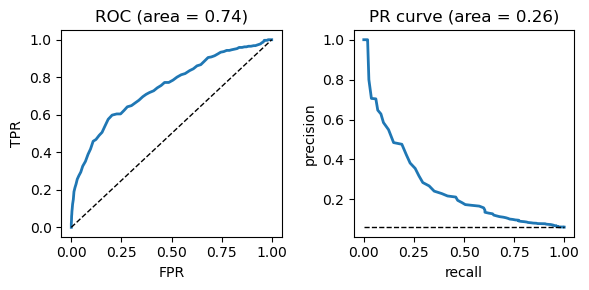

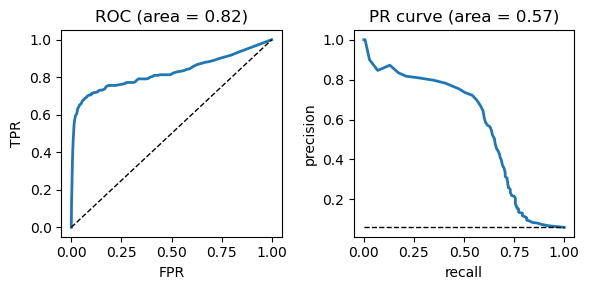

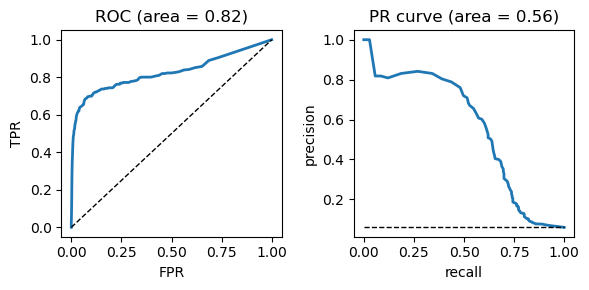

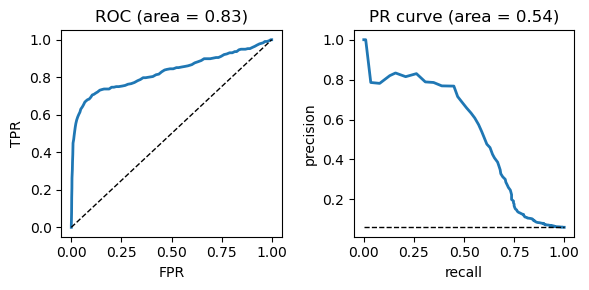

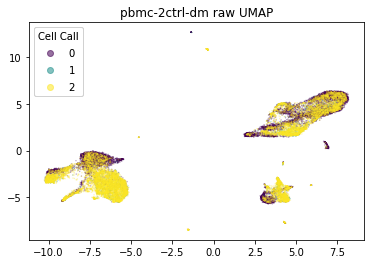

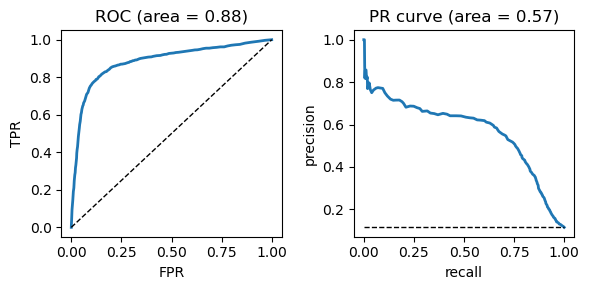

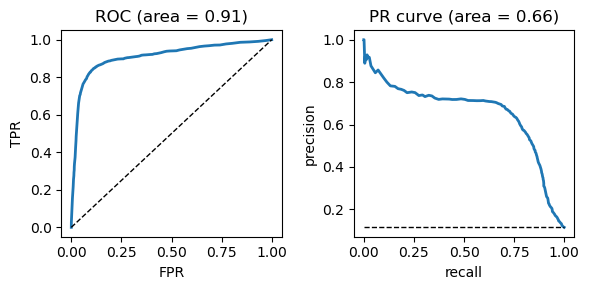

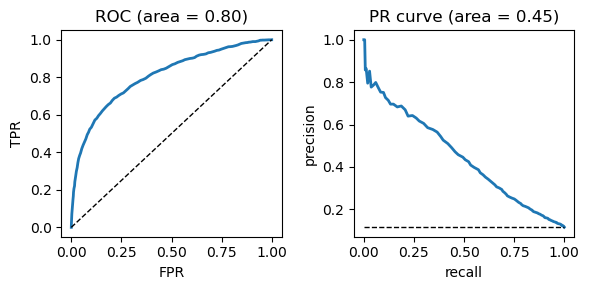

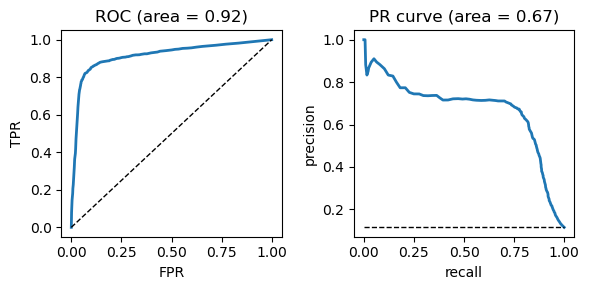

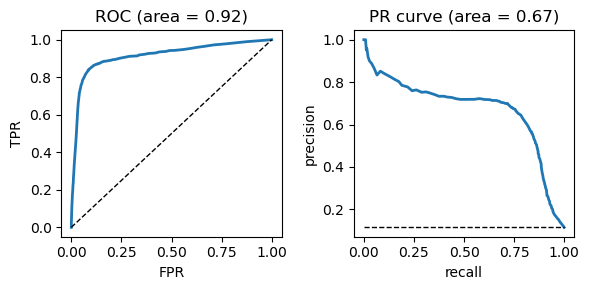

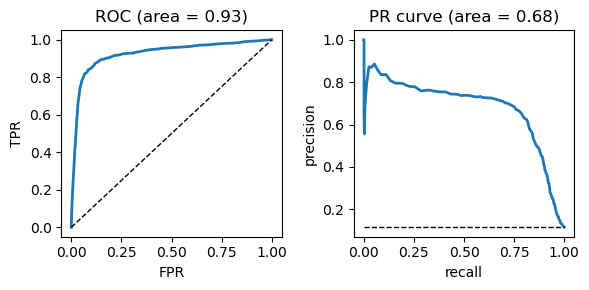

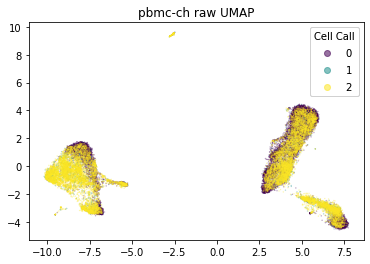

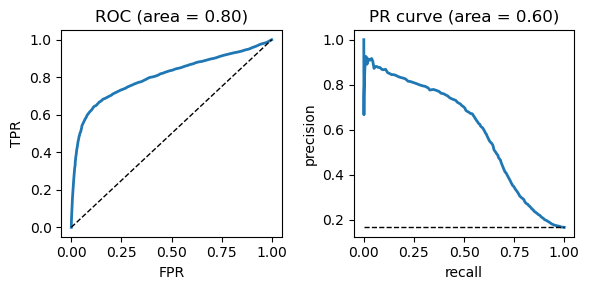

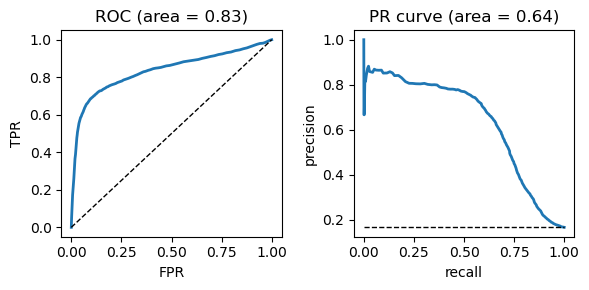

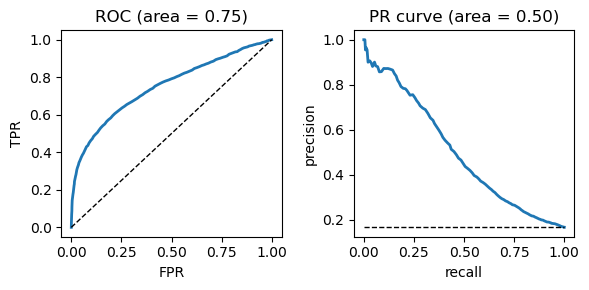

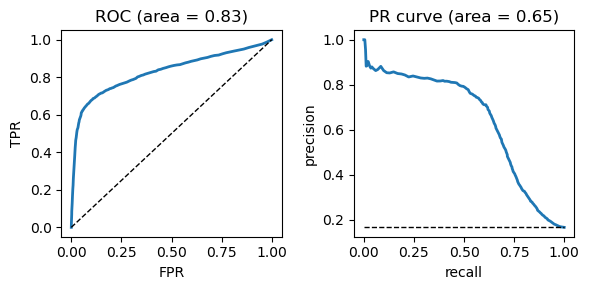

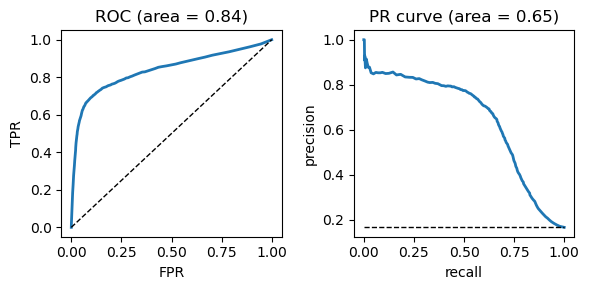

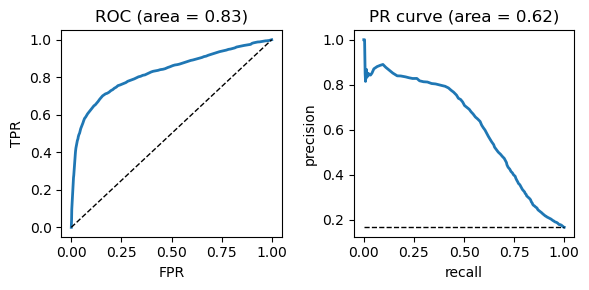

<Figure size 432x288 with 0 Axes>

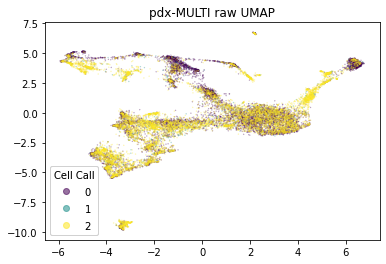

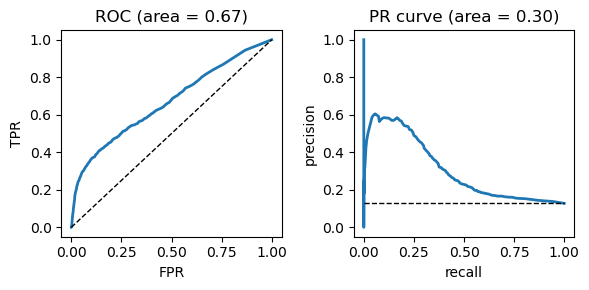

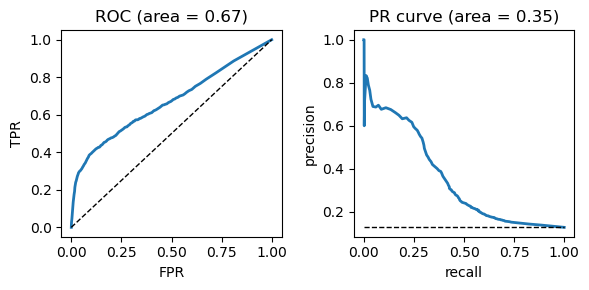

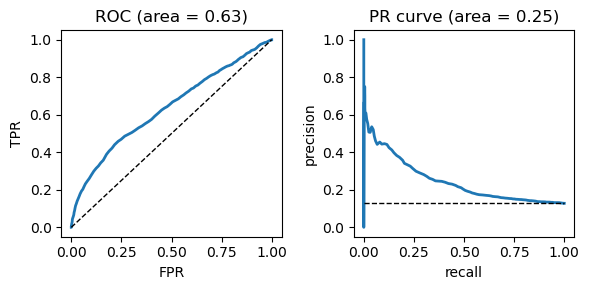

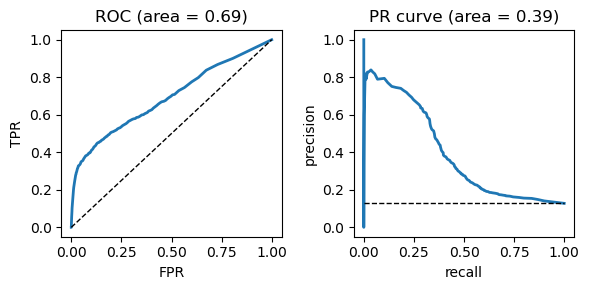

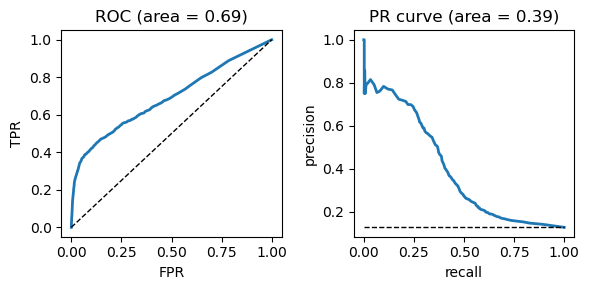

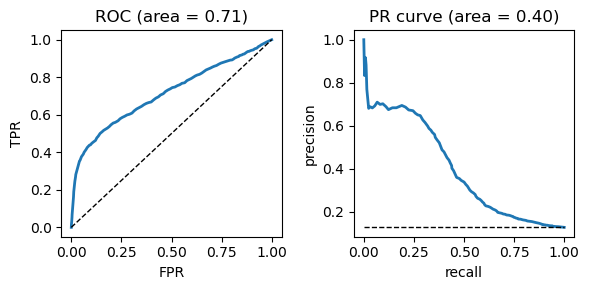

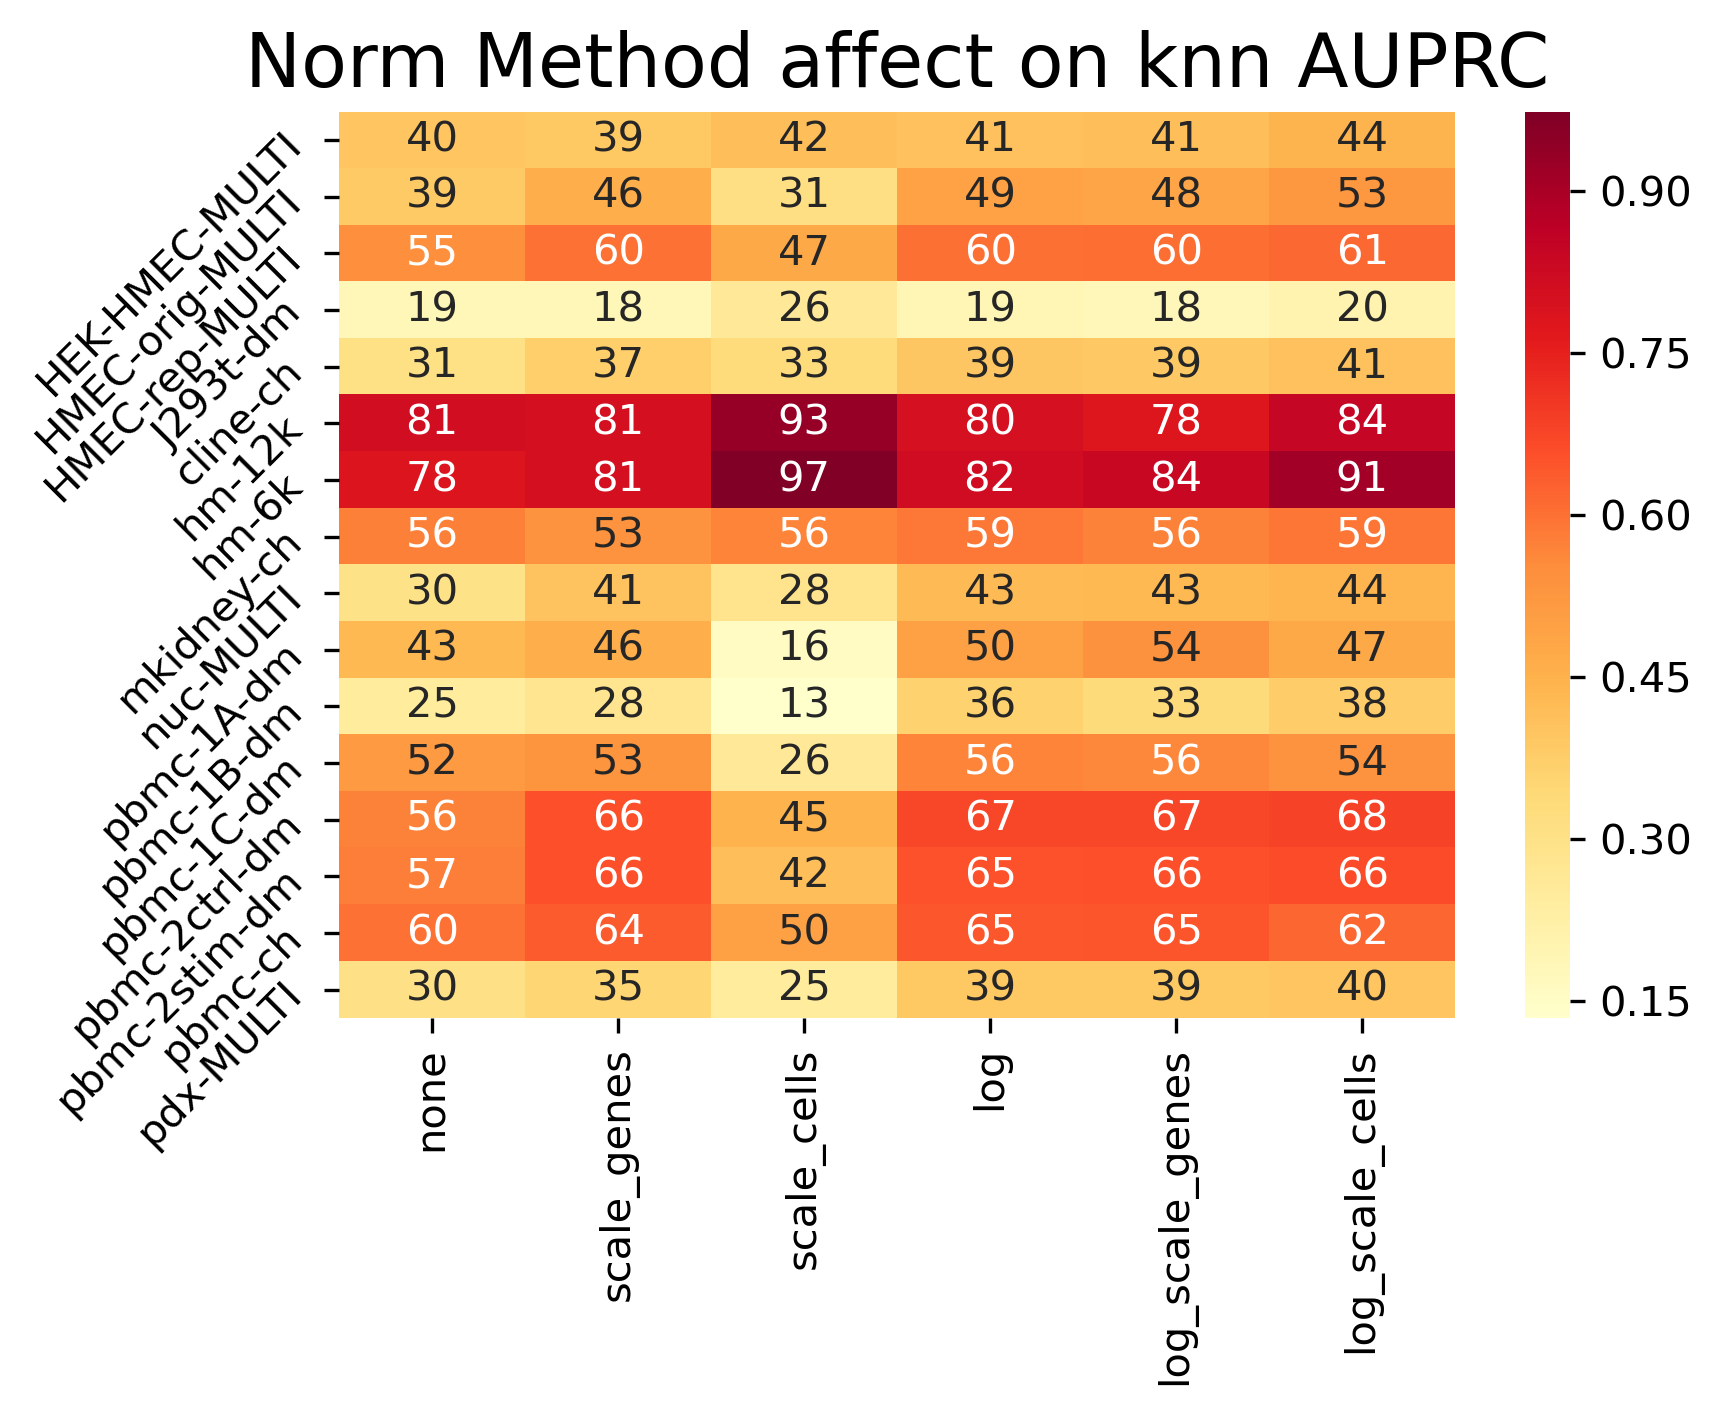

In [2]:
import numpy as np
import scipy.sparse as scs
from scipy.stats import multinomial
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import mmread

import umap as um


from os import listdir
from os.path import isfile, join
import os

import random

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import seaborn as sns

from sklearn.preprocessing import StandardScaler


#from plot_results import get_dbl_metrics

path = '../data/sce_normalized_data_inflate/'
data_dir = 'sce_normalized_data_inflate'
files = [f for f in listdir(path) if (isfile(join(path, f)) & (f[-18:-4] == 'real_logcounts'))]

#files = files[0:2] 

norms = ['none', 'scale_genes', 'scale_cells', 'log', 'log_scale_genes', 'log_scale_cells']
#norms = ['log', 'log_scale_genes', 'log_scale_cells']

data_names = [f[:-19] for f in listdir(path) if (isfile(join(path, f)) & (f[-18:-4] == 'real_logcounts'))]
#data_names = data_names[0:2]
tmp1 = np.zeros((len(data_names), len(norms)))
hm = pd.DataFrame(tmp1, index=np.sort(data_names), columns=norms)

for file in files:

    data_name = file[:-19]

    print(data_name)    
    
    #scvae-dbl-btch/data/sce_normalized_data_inflate/pdx-MULTI_real_logcounts.mtx
    real_path = '../data/'+ data_dir + '/' + data_name + '_real_counts.mtx'
    sim_path = '../data/'+ data_dir + '/' + data_name + '_sim_counts.mtx'
    ano_path  = '../data/'+ data_dir + '/' + data_name + '_anno.csv'
    umap_path = '../data/'+ data_dir + '/' + data_name + '_UMAP.npy'
    hvg_path = '../data/'+ data_dir + '/' + data_name + '_hvgs_realANDsim.npy'    
    
    save_path = '../results_knn/' + data_dir 
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    save_path = save_path + '/' 
    print(save_path)
        
    #- READ IN COUNTS
    cnts_file_real = pl.Path(real_path)
    cnts_file_sim = pl.Path(sim_path)
    if (cnts_file_real.exists() &  cnts_file_sim.exists()):
        dat_real = mmread(cnts_file_real)
        dat_sim = mmread(cnts_file_sim)
        #dat = np.load(cnts_file)#csr sparse matrix format
    else:
        print('does not exist')

    Xr = scs.csr_matrix(dat_real).toarray().T
    Xs = scs.csr_matrix(dat_sim).toarray().T
    X = np.vstack([Xr,Xs])
    
    #- READ IN BARCODE ANNOTATIONS
    ano = pd.read_csv(ano_path)
    true = pd.factorize(ano.x)[0]
    labels = ano.x
    if (labels[0]=='doublet'):
        tmp = true + 3
        tmp[tmp==3] = 1
        tmp[tmp==4] = 0
        true = tmp
    true = np.concatenate([true, np.full(Xs.shape[0],2)])
    labels = np.concatenate([labels, np.full(Xs.shape[0],'simulated')])

    #- READ IN UMAP
    proj = np.load(umap_path)

    #- HVGs - NEED TO CHECK IF THESE ARE THE RIGHT ORDER THOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
    hvgs = (np.load(hvg_path)).astype(int) - 1
    
    X = X[:,hvgs]
    Y = (true>1).astype(int)

    plt.figure(30)
    fig, ax = plt.subplots()
    scatter = ax.scatter(proj[:,0],proj[:,1], c=true, s=0.1, alpha=0.5)
    legend = ax.legend(*scatter.legend_elements(), title= 'Cell Call')
    plt.title(data_name + ' raw UMAP')
    ax.add_artist(legend)

    #HYPERPARAMS
    neighbors = int(np.sqrt(X.shape[0]))
    projections = True
    save_figs = True
    comp = 40

    for norm in norms:
        
        if (norm=='none'):
            Xn = X
        elif (norm=='scale_genes'):
            #SCALE THE FEATURES
            scaler = StandardScaler().fit(X)
            Xn = scaler.transform(X)
        elif (norm=='scale_cells'):
            #SCALE THE CELLS
            scaler = StandardScaler().fit(X.T)
            Xn = scaler.transform(X.T).T
        elif (norm=='log'):
            Xn = np.log1p(X)
        elif (norm=='log_scale_genes'):
            Xn = np.log1p(X)
            scaler = StandardScaler().fit(Xn)
            Xn = scaler.transform(Xn)
        elif (norm=='log_scale_cells'):
            Xn = np.log1p(X)
            scaler = StandardScaler().fit(Xn.T)
            Xn = scaler.transform(Xn.T).T
            
        #KNN
        pca = PCA(n_components=comp)
        pca_proj = pca.fit_transform(Xn)

        np.random.seed(42)
        knn = NearestNeighbors(n_neighbors=neighbors)
        knn.fit(pca_proj,Y)
        graph = knn.kneighbors_graph(pca_proj)
        knn_feature = np.squeeze(np.array(np.sum(graph[:,Y==1], axis=1) / neighbors)) #sum across rows

        rauc, prauc, ap = get_dbl_metrics(true[true<2], knn_feature[true<2])
        hm[norm].loc[data_name] = prauc
        
        

mk_heatmap(hm, title = 'Norm Method affect on knn AUPRC')
plt.savefig(save_path + 'dataset_vs_Norm.png', dpi=600)
hm.to_csv(save_path + 'dataset_vs_Norm.csv')
